In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from PIL import Image, ImageFile
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
train_transformer = transforms.Compose([
    #transforms.Resize((64,64)),
    #transforms.RandomHorizontalFlip(p=0.5),  
    #transforms.RandomVerticalFlip(p=0.5),  
    transforms.ToTensor()
    ])
                 
val_transformer = transforms.Compose([
    #transforms.Resize((64,64)),
    transforms.ToTensor()
    ])

test_transformer = transforms.Compose([
    #transforms.Resize((64,64)),
    transforms.ToTensor()
    ])

In [3]:
train_data_path = "./dataset/train/"
train_ds = torchvision.datasets.ImageFolder(root=train_data_path,transform=train_transformer)

val_data_path = "./dataset/val/"
val_ds = torchvision.datasets.ImageFolder(root=val_data_path,transform=val_transformer)

test_data_path = "./dataset/test/"
test_ds = torchvision.datasets.ImageFolder(root=test_data_path,transform=test_transformer)

In [4]:
print(f'Number of training examples: {len(train_ds)}')
print(f'Number of validation examples: {len(val_ds)}')
print(f'Number of test examples: {len(test_ds)}')

Number of training examples: 5787
Number of validation examples: 722
Number of test examples: 727


image indices: [5099   79 5709 4813]
torch.Size([3, 1156, 4618])


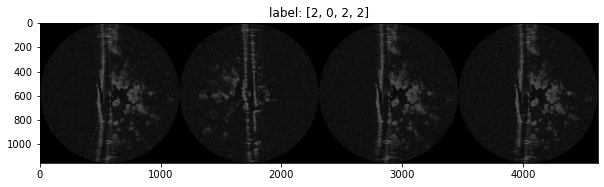

In [5]:
from torchvision import utils
%matplotlib inline

# fix random seed
np.random.seed()

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [6]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=False) 

In [7]:
from torchvision import models
import torch

# load model with pretrained weights
resnet18_pretrained = models.resnet18(pretrained=True)

# change the output layer
num_classes=3
num_ftrs = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:0")
resnet18_pretrained.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
loss_func = nn.CrossEntropyLoss(reduction="sum")

In [11]:
from torch import optim
opt = optim.Adam(resnet18_pretrained.parameters(), lr=1e-4)

In [12]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [13]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# define learning rate scheduler
lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)

In [14]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [15]:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [16]:
# define device as a global variable
device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [17]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [18]:
import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(resnet18_pretrained.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 20,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "./models/resnet18_pretrained_v1.pt",
}

# train and validate the model
resnet18_pretrained,loss_hist,metric_hist=train_val(resnet18_pretrained,params_train)

Epoch 0/19, current lr=0.0001
Copied best model weights!
train loss: 0.064290, dev loss: 0.000506, accuracy: 100.00
----------
Epoch 1/19, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.010560, dev loss: 0.000185, accuracy: 100.00
----------
Epoch 2/19, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.010762, dev loss: 0.000178, accuracy: 100.00
----------
Epoch 3/19, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.001409, dev loss: 0.000102, accuracy: 100.00
----------
Epoch 4/19, current lr=1.0453658778440105e-05
train loss: 0.002006, dev loss: 0.000194, accuracy: 100.00
----------
Epoch 5/19, current lr=1e-06
Copied best model weights!
train loss: 0.001957, dev loss: 0.000088, accuracy: 100.00
----------
Epoch 6/19, current lr=1.0453658778440102e-05
Copied best model weights!
train loss: 0.000701, dev loss: 0.000051, accuracy: 100.00
----------
Epoch 7/19, current lr=3.520365877844011e-05
Copied best model we

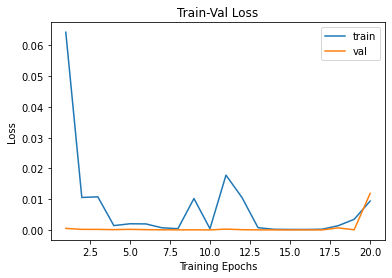

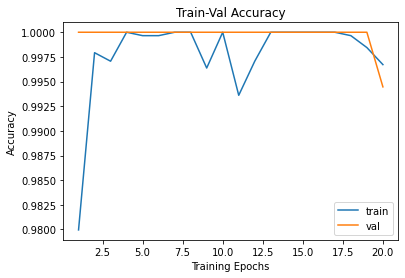

In [19]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [20]:
data_dir = test_data_path

model = resnet18_pretrained
model.load_state_dict(torch.load("./models/resnet18_pretrained_v1.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
def predict_image(image):
    image_tensor = test_transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transformer)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [28]:
classes = ['fog','rain','sunny']

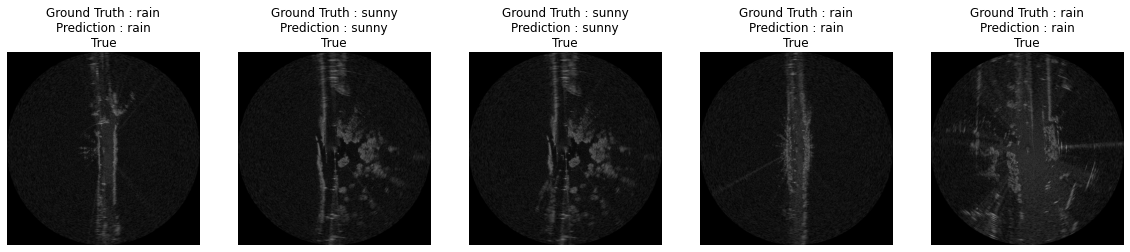

In [29]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title("Ground Truth : "+ classes[int(labels[ii])] +"\n"+"Prediction : "+str(classes[index])+"\n"+str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()